# 케라스 전이 학습(Transfer Learning)

<img src="https://miro.medium.com/max/5252/1*Z11P-CjNYWBofEbmGQrptA.png">

<sub>출처: https://medium.com/the-official-integrate-ai-blog/transfer-learning-explained-7d275c1e34e2</sub>


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import *

In [2]:
vgg16 = VGG16(weights='imagenet', 
              input_shape=(32, 32, 3), 
              include_top=False)

58892288/58889256 [==============================] - 0s 0us/step


In [6]:
model = Sequential()
model.add(vgg16)

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2570      
Total params: 14,849,610
Trainable params: 14,849,098
Non-trainable params: 512
________________________________________

In [7]:
mobilenet = MobileNet(weights=None, input_shape=None, include_top=True)

resnet50 = ResNet50(weights=None, input_shape=None, include_top=True)

Xception = Xception(weights=None, input_shape=None, include_top=True)

### 예제 : Dogs vs Cats
- Kaggle Data 이용: https://www.kaggle.com/c/dogs-vs-cats/data

- ImageDataGenerator의 flow_from_directory 이용

- 런타임 유형 GPU 사용

- 출처: https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part2.ipynb#scrollTo=SdW6geEVi2S8

#### modules import

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, MaxPool2D, Input, Dropout, Dense
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

import os
import zipfile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

#### 데이터 로드

In [14]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  /content/cats_and_dogs_filtered.zip

--2020-10-21 07:19:26--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.195.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   111MB/s    in 0.6s    

2020-10-21 07:19:27 (111 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]

/content/cats_and_dogs_filtered.zip: Scheme missing.
FINISHED --2020-10-21 07:19:27--
Total wall clock time: 0.8s
Downloaded: 1 files, 65M in 0.6s (111 MB/s)


In [16]:
local_zip = '/content/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [17]:
base_dir = '/content/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [18]:
train_cats_dir = os.path.join(train_dir, 'cats')

train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')

validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

#### 이미지 보강된 데이터 확인

In [20]:
datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range= 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

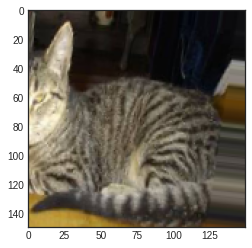

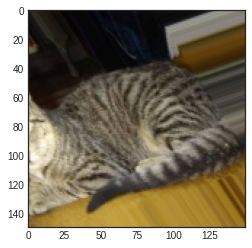

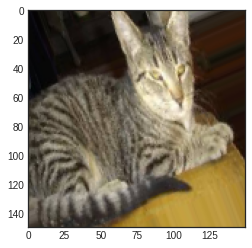

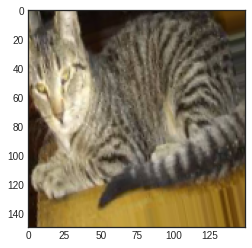

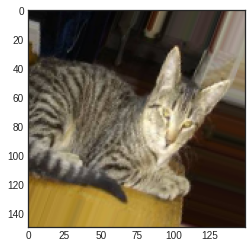

In [21]:
img_path = os.path.join(train_cats_dir, train_cat_fnames[2])
img = load_img(img_path, target_size=(150, 150))
x = img_to_array(img)
x = x.reshape((1, ) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 5 == 0:
    break

#### 학습, 검증 데이터셋의 Data Generator

In [22]:
train_datagen = ImageDataGenerator(
    rescale=1./255 ,
    rotation_range=40, 
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150), 
    batch_size = 20,
    class_mode = 'binary'
)

val_datagen = ImageDataGenerator(rescale=1./255)

validation_gen = val_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### 모델 구성 및 컴파일

In [23]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D(2, 2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['acc'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

#### 모델 학습 및 학습 과정 시각화
- 런타임유형 GPU 사용

In [25]:
history = model.fit(train_generator, 
                    steps_per_epoch = 100,
                    epochs = 30,
                    batch_size = 256,
                    validation_data = validation_gen, 
                    validation_steps = 50, 
                    verbose = 2)

Epoch 1/30
100/100 - 16s - loss: 0.6919 - acc: 0.5185 - val_loss: 0.6946 - val_acc: 0.5000
Epoch 2/30
100/100 - 16s - loss: 0.6889 - acc: 0.5175 - val_loss: 0.6783 - val_acc: 0.5850
Epoch 3/30
100/100 - 16s - loss: 0.6769 - acc: 0.5820 - val_loss: 0.6850 - val_acc: 0.5340
Epoch 4/30
100/100 - 16s - loss: 0.6659 - acc: 0.5895 - val_loss: 0.6255 - val_acc: 0.6530
Epoch 5/30
100/100 - 16s - loss: 0.6325 - acc: 0.6450 - val_loss: 0.5809 - val_acc: 0.6890
Epoch 6/30
100/100 - 16s - loss: 0.6078 - acc: 0.6615 - val_loss: 0.6281 - val_acc: 0.6490
Epoch 7/30
100/100 - 16s - loss: 0.6181 - acc: 0.6610 - val_loss: 0.5927 - val_acc: 0.6650
Epoch 8/30
100/100 - 16s - loss: 0.5958 - acc: 0.6785 - val_loss: 0.5603 - val_acc: 0.6900
Epoch 9/30
100/100 - 16s - loss: 0.5833 - acc: 0.6825 - val_loss: 0.5533 - val_acc: 0.7090
Epoch 10/30
100/100 - 16s - loss: 0.5847 - acc: 0.6930 - val_loss: 0.5555 - val_acc: 0.7060
Epoch 11/30
100/100 - 16s - loss: 0.5747 - acc: 0.6955 - val_loss: 0.5307 - val_acc: 0.72

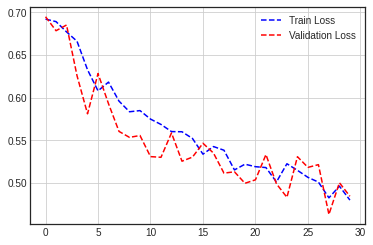

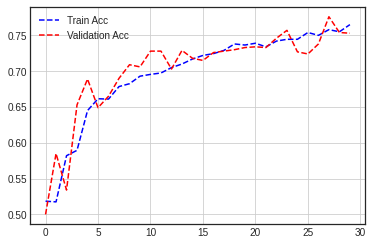

In [26]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b--', label='Train Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'b--', label='Train Acc')
plt.plot(epochs, val_acc, 'r--', label='Validation Acc')
plt.grid()
plt.legend()

plt.show()

#### 모델 저장

In [28]:
model.save('cats_and_dogs_model.h5')

### 사전 훈련된 모델 사용

In [29]:
conv_base = VGG16(weights='imagenet', 
                  input_shape=(150, 150, 3), 
                  include_top = False)

In [30]:
from tensorflow.keras.optimizers import RMSprop

def build_model_with_pretrained(conv_base):
  model = Sequential()
  model.add(conv_base)
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', 
                optimizer=RMSprop(learning_rate=2e-5), 
                metrics=['accuracy'])
  
  return model

파라미터의 수 확인!

In [31]:
model = build_model_with_pretrained(conv_base)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


#### 레이어 동결
- 훈련하기 전, 합성곱 기반 레이어들의 가중치 학습을 막기 위해 이를 동결

In [32]:
print(len(model.trainable_weights))

30


In [33]:
conv_base.trainable = False
print(len(model.trainable_weights))

4


#### 모델 컴파일
- trainable 속성을 변경했기 때문에 다시 모델을 컴파일 해야함

In [ ]:
model.compile(loss='binary_crossentropy', 
                optimizer=Adam(learning_rate=2e-5), 
                metrics=['accuracy'])

#### 이미지 제너레이터

In [34]:
train_datagen = ImageDataGenerator(
    rescale=1./255 ,
    rotation_range=40, 
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150), 
    batch_size = 20,
    class_mode = 'binary'
)

val_datagen = ImageDataGenerator(rescale=1./255)

validation_gen = val_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### 모델 재학습

In [35]:
history2 = model.fit(train_generator, 
                    steps_per_epoch = 100,
                    epochs = 30,
                    batch_size = 256,
                    validation_data = validation_gen, 
                    validation_steps = 50, 
                    verbose = 2)

Epoch 1/30
100/100 - 23s - loss: 0.4393 - accuracy: 0.7880 - val_loss: 0.5222 - val_accuracy: 0.7610
Epoch 2/30
100/100 - 23s - loss: 0.2857 - accuracy: 0.8855 - val_loss: 0.6153 - val_accuracy: 0.7640
Epoch 3/30
100/100 - 22s - loss: 0.2205 - accuracy: 0.9190 - val_loss: 0.1157 - val_accuracy: 0.9610
Epoch 4/30
100/100 - 23s - loss: 0.1896 - accuracy: 0.9255 - val_loss: 0.1241 - val_accuracy: 0.9510
Epoch 5/30
100/100 - 23s - loss: 0.1506 - accuracy: 0.9435 - val_loss: 0.1322 - val_accuracy: 0.9560
Epoch 6/30
100/100 - 23s - loss: 0.1356 - accuracy: 0.9470 - val_loss: 0.1019 - val_accuracy: 0.9600
Epoch 7/30
100/100 - 23s - loss: 0.1136 - accuracy: 0.9510 - val_loss: 0.0924 - val_accuracy: 0.9680
Epoch 8/30
100/100 - 23s - loss: 0.1101 - accuracy: 0.9565 - val_loss: 0.1124 - val_accuracy: 0.9600
Epoch 9/30
100/100 - 23s - loss: 0.1022 - accuracy: 0.9595 - val_loss: 0.0979 - val_accuracy: 0.9660
Epoch 10/30
100/100 - 23s - loss: 0.0876 - accuracy: 0.9675 - val_loss: 0.0940 - val_accura

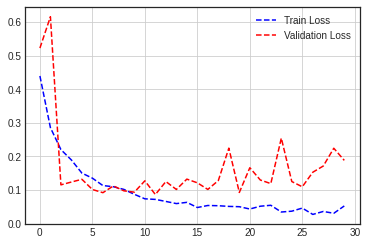

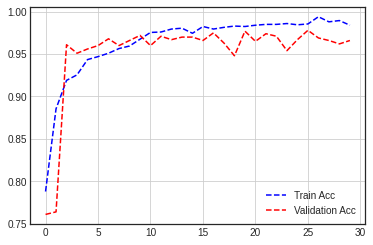

In [36]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b--', label='Train Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'b--', label='Train Acc')
plt.plot(epochs, val_acc, 'r--', label='Validation Acc')
plt.grid()
plt.legend()

plt.show()

#### 모델 저장

In [37]:
model.save('cats_and_dogs_with_pretrained_model.h5')

## Feature Map 시각화

In [38]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

### 모델 구성

In [39]:
model = load_model('/content/cats_and_dogs_model.h5')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [40]:
img_path = '/content/cats_and_dogs_filtered/validation/dogs/dog.2000.jpg'

img = image.load_img(img_path, target_size=(150,150))
img_tensor = image.img_to_array(img)
img_tensor = img_tensor[np.newaxis, ...]
img_tensor /= 255.
print(img_tensor.shape)

(1, 150, 150, 3)


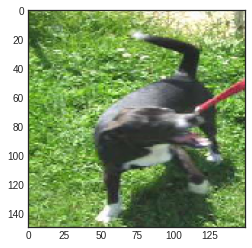

In [41]:
plt.imshow(img_tensor[0])
plt.show()

In [42]:
conv_output = [layer.output for layer in model.layers[:8]]
conv_output

[<tf.Tensor 'conv2d_4/Relu_1:0' shape=(None, 148, 148, 32) dtype=float32>,
 <tf.Tensor 'max_pooling2d/MaxPool_1:0' shape=(None, 74, 74, 32) dtype=float32>,
 <tf.Tensor 'conv2d_5/Relu_1:0' shape=(None, 72, 72, 64) dtype=float32>,
 <tf.Tensor 'max_pooling2d_1/MaxPool_1:0' shape=(None, 36, 36, 64) dtype=float32>,
 <tf.Tensor 'conv2d_6/Relu_1:0' shape=(None, 34, 34, 128) dtype=float32>,
 <tf.Tensor 'max_pooling2d_2/MaxPool_1:0' shape=(None, 17, 17, 128) dtype=float32>,
 <tf.Tensor 'conv2d_7/Relu_1:0' shape=(None, 15, 15, 128) dtype=float32>,
 <tf.Tensor 'max_pooling2d_3/MaxPool_1:0' shape=(None, 7, 7, 128) dtype=float32>]

In [43]:
activation_model = Model(inputs=[model.input], outputs=conv_output)

In [44]:
activations = activation_model.predict(img_tensor)

In [45]:
len(activations)

8

### 시각화

(1, 148, 148, 32)


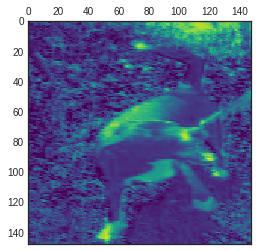

In [46]:
print(activations[0].shape)
plt.matshow(activations[0][0, :, :, 7], cmap='viridis')
plt.show()

(1, 148, 148, 32)


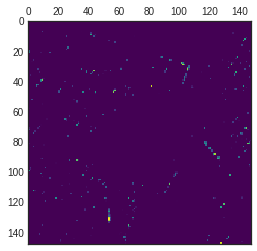

In [47]:
print(activations[0].shape)
plt.matshow(activations[0][0, :, :, 10], cmap='viridis')
plt.show()

(1, 148, 148, 32)


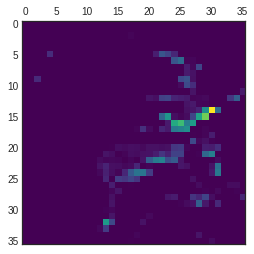

In [48]:
print(activations[0].shape)
plt.matshow(activations[3][0, :, :, 20], cmap='viridis')
plt.show()

### 중간의 모든 활성화에 대해 시각화

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


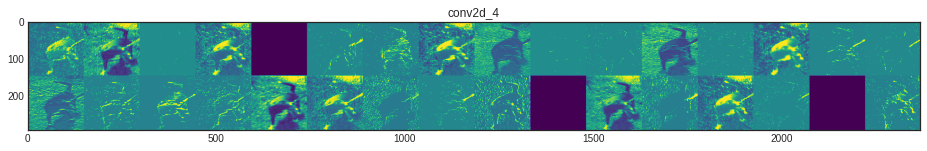

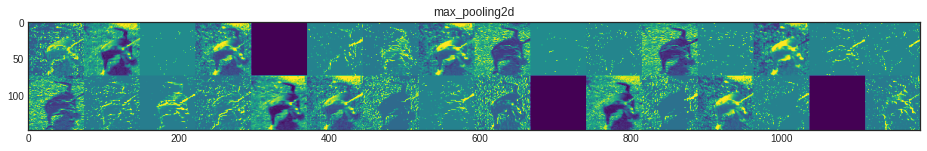

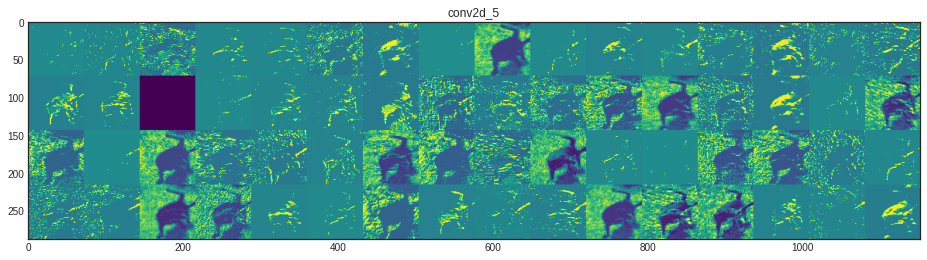

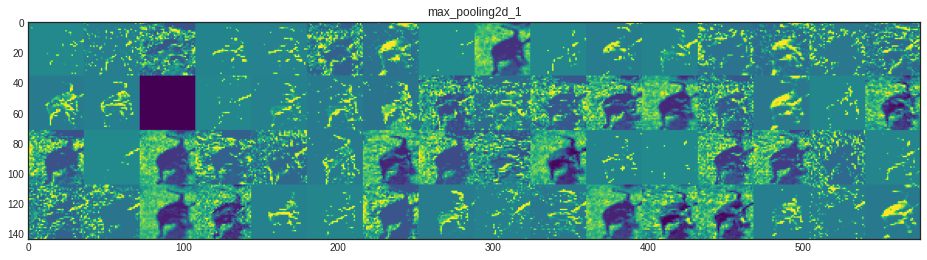

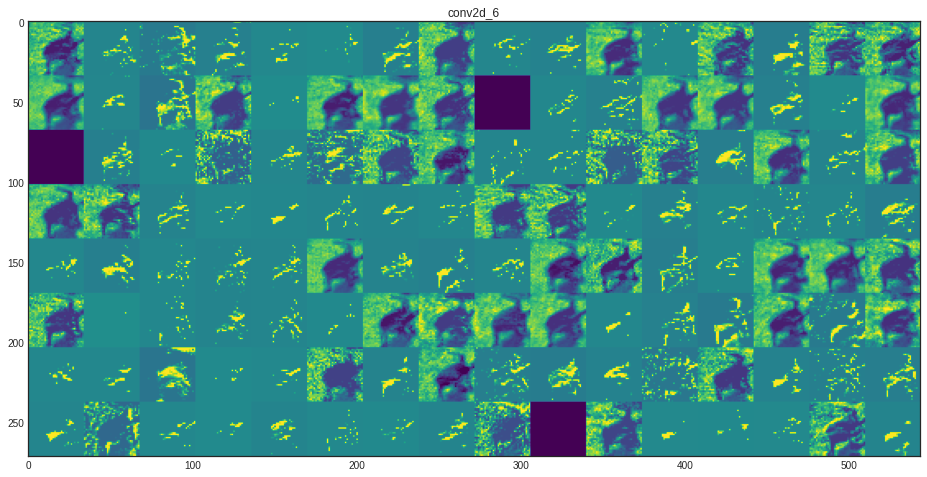

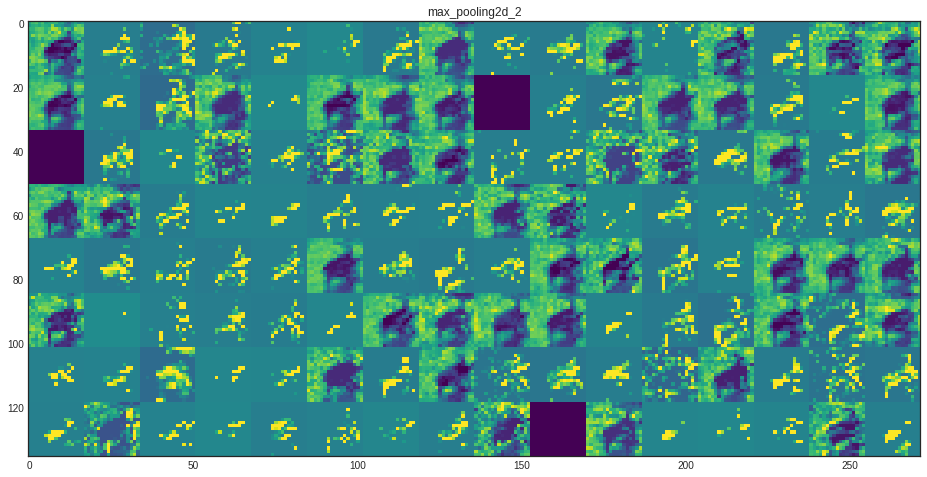

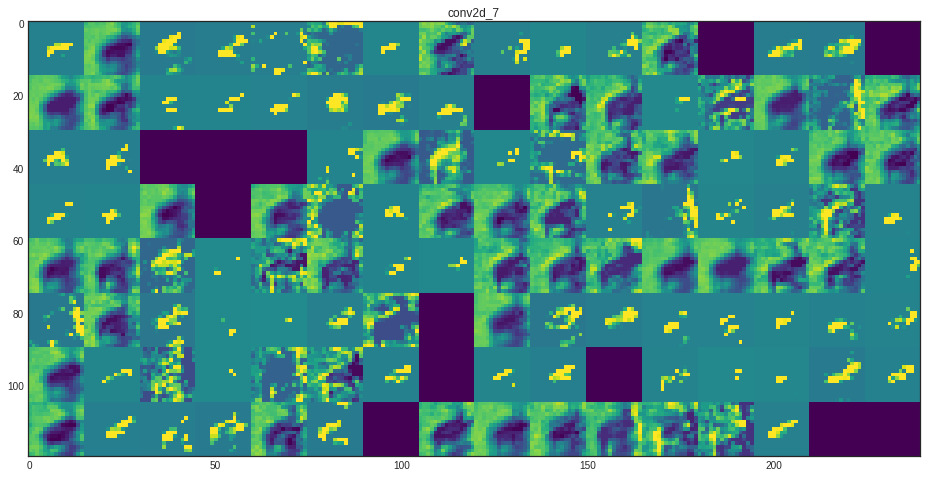

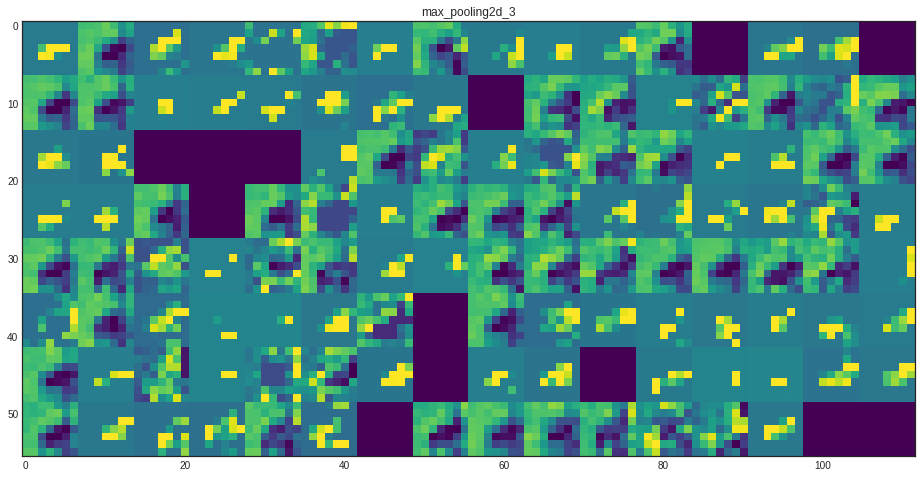

In [51]:
layer_names = []
for layer in model.layers[:8]:
  layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
  num_features = layer_activation.shape[-1]

  size = layer_activation.shape[1]

  num_cols = num_features // images_per_row

  display_grid = np.zeros((size * num_cols, images_per_row * size))

  for col in range(num_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0, :, :, col * images_per_row + row]
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size: (col+1) * size, row * size : (row + 1) * size] = channel_image

  scale = 1. /size

  plt.figure(figsize=(scale * display_grid.shape[1],
                      scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()